In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]

random.seed(1411)
np.random.seed(1411)

It looks like it's safe to drop everything that has a price over 100000 as the sample contains a negligeable number of observations with that price. There are also 26000 observations with the price set to 0. The hypothesis here is that these are probably cars that are either given out for free or just bad data. Will remove them as well. Odometer over 600000 also seems quite unreasonable, that's like going from SF to NY over 200 times, so will drop those observations as well.

In [2]:
cars = pd.read_csv("vehicles.csv")
cars = cars[((cars["price"] > 100) & (cars["price"] < 100000))]
cars = cars[
    (cars["odometer"] < 600000.0) & 
    ((cars["odometer"] > 100) | (cars["condition"] == "new"))
]

Some columns that have missing data, contain some information in the description column or in the model column. I'll try to backfill the data in case I will use these features later on.

In [3]:
def backfill_column(x, column_name, values):
    if pd.notna(x[column_name]):
        return x[column_name]
    
    for value in values:        
        if value in str(x["description"]) or value in str(x["model"]):
            return value

Some columns I won't look at them because I don't believe they have predictive power. Id, url, image_url are not properties of the car sold but rather of the posting so unlikely to be useful. County is not clean, and might take a while to normalise and clean so will drop as well. 

In [4]:
cars = cars.drop(columns=["id", "url", "VIN", "image_url", "county", "posting_date", "size"])

manufacturer = set(cars["manufacturer"].astype(str).unique())
fuel = set(cars["fuel"].astype(str).unique())
color = set(cars["paint_color"].astype(str).unique())
car_type = set(cars["type"].astype(str).unique())
cars["manufacturer"] = cars.apply(lambda x: backfill_column(x, "manufacturer", manufacturer), axis=1)
cars["fuel"] = cars.apply(lambda x: backfill_column(x, "fuel", fuel), axis=1)
cars["paint_color"] = cars.apply(lambda x: backfill_column(x, "paint_color", color), axis=1)
cars["type"] = cars.apply(lambda x: backfill_column(x, "type", car_type), axis=1)

cars = cars.drop(columns=["model", "description"])

### What's the percentage of missing values for each feature ? 

In [5]:
nr_cars = len(cars)
cars.isna().sum()/nr_cars

region          0.000000
region_url      0.000000
price           0.000000
year            0.002591
manufacturer    0.019074
condition       0.380602
cylinders       0.403768
fuel            0.002968
odometer        0.000000
title_status    0.018233
transmission    0.003812
drive           0.302130
type            0.092166
paint_color     0.085349
state           0.000000
lat             0.008599
long            0.008599
dtype: float64

Dropping rows that have NAs in them and have less than 10% of the observations. There are alternatives to try populating them based on the description column or the model, which include more information but will not consider that in an initial phase. The columns with over 30% will consider later, after doing some exploratory analysis. 

In [6]:
cars = cars.dropna(subset=["lat", "long", "odometer", "year", "fuel", "transmission", "manufacturer", "type"])

In [7]:
cars["year"] = cars["year"].astype("int")
cars["lat"] = cars["lat"].astype("float64")
cars["long"] = cars["long"].astype("float64")

In [8]:
round(cars.describe(), 1)

,price,year,odometer,lat,long
count,334790.0,334790.0,334790.0,334790.0,334790.0
mean,19592.1,2011.7,91032.9,38.6,-94.5
std,14364.8,8.5,62789.6,5.8,18.2
min,101.0,1900.0,0.0,-81.8,-159.7
25%,7995.0,2009.0,37332.0,34.7,-111.8
50%,16500.0,2014.0,84563.0,39.3,-88.0
75%,28590.0,2017.0,132500.0,42.5,-81.0
max,99999.0,2022.0,590000.0,82.4,139.7


## Exploratory analysis

##### How does the price distribution looks like ?

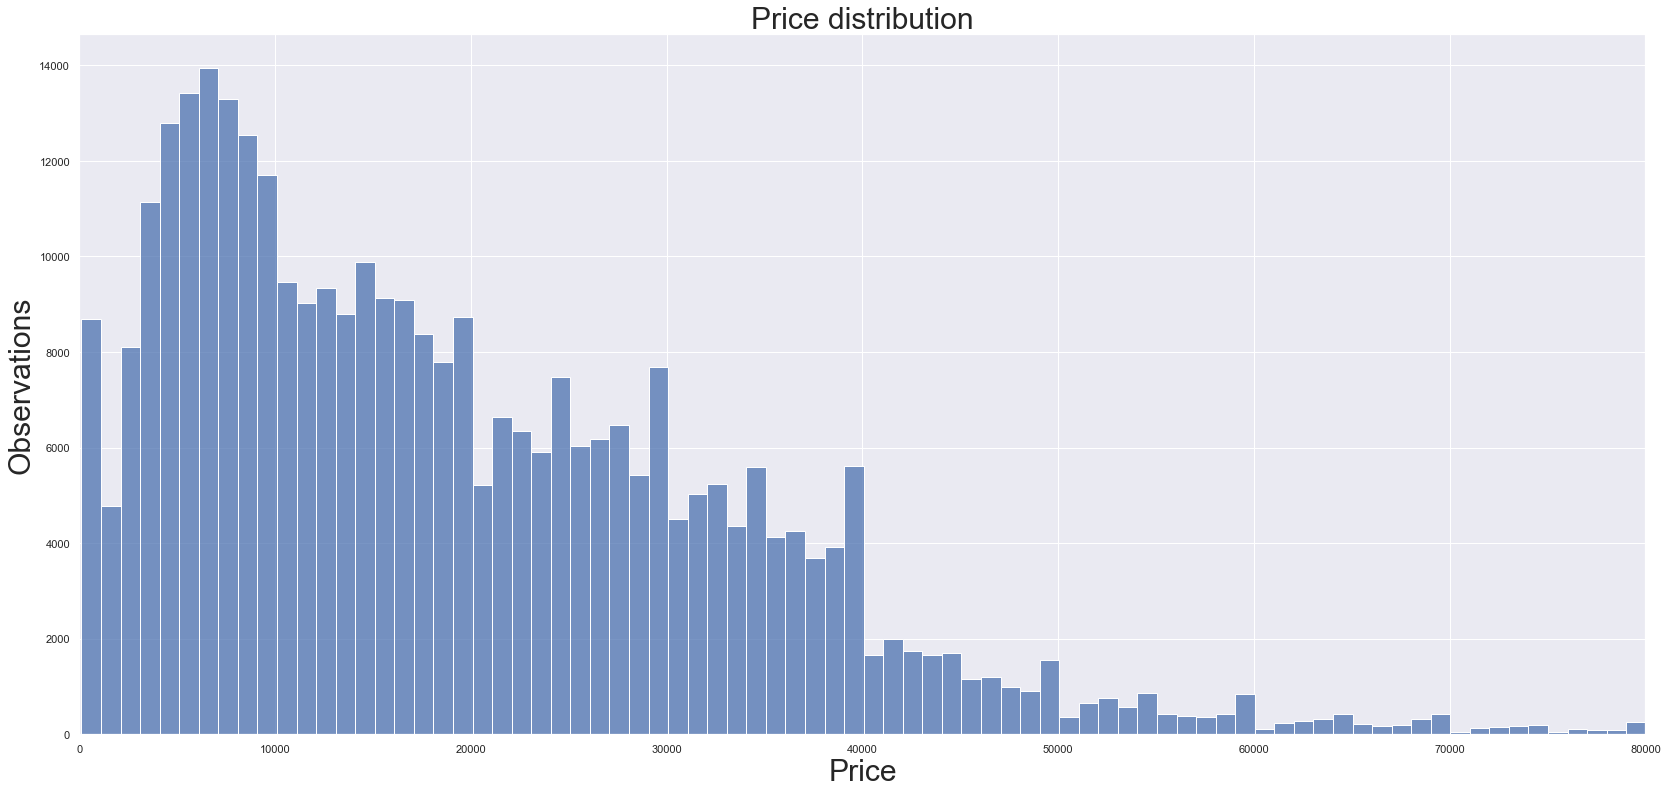

In [9]:
fig, ax = plt.subplots()
p = sns.histplot(cars["price"], bins=100)
p.axes.set_title("Price distribution",fontsize=30)
p.set_xlabel("Price",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 80000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

I think this is as expected. Prices will be positive (0 truncated) and the number of cars decrease with the increase of price. 

#### Distribution of prices by existing properties

Text(0, 0.5, 'Density')

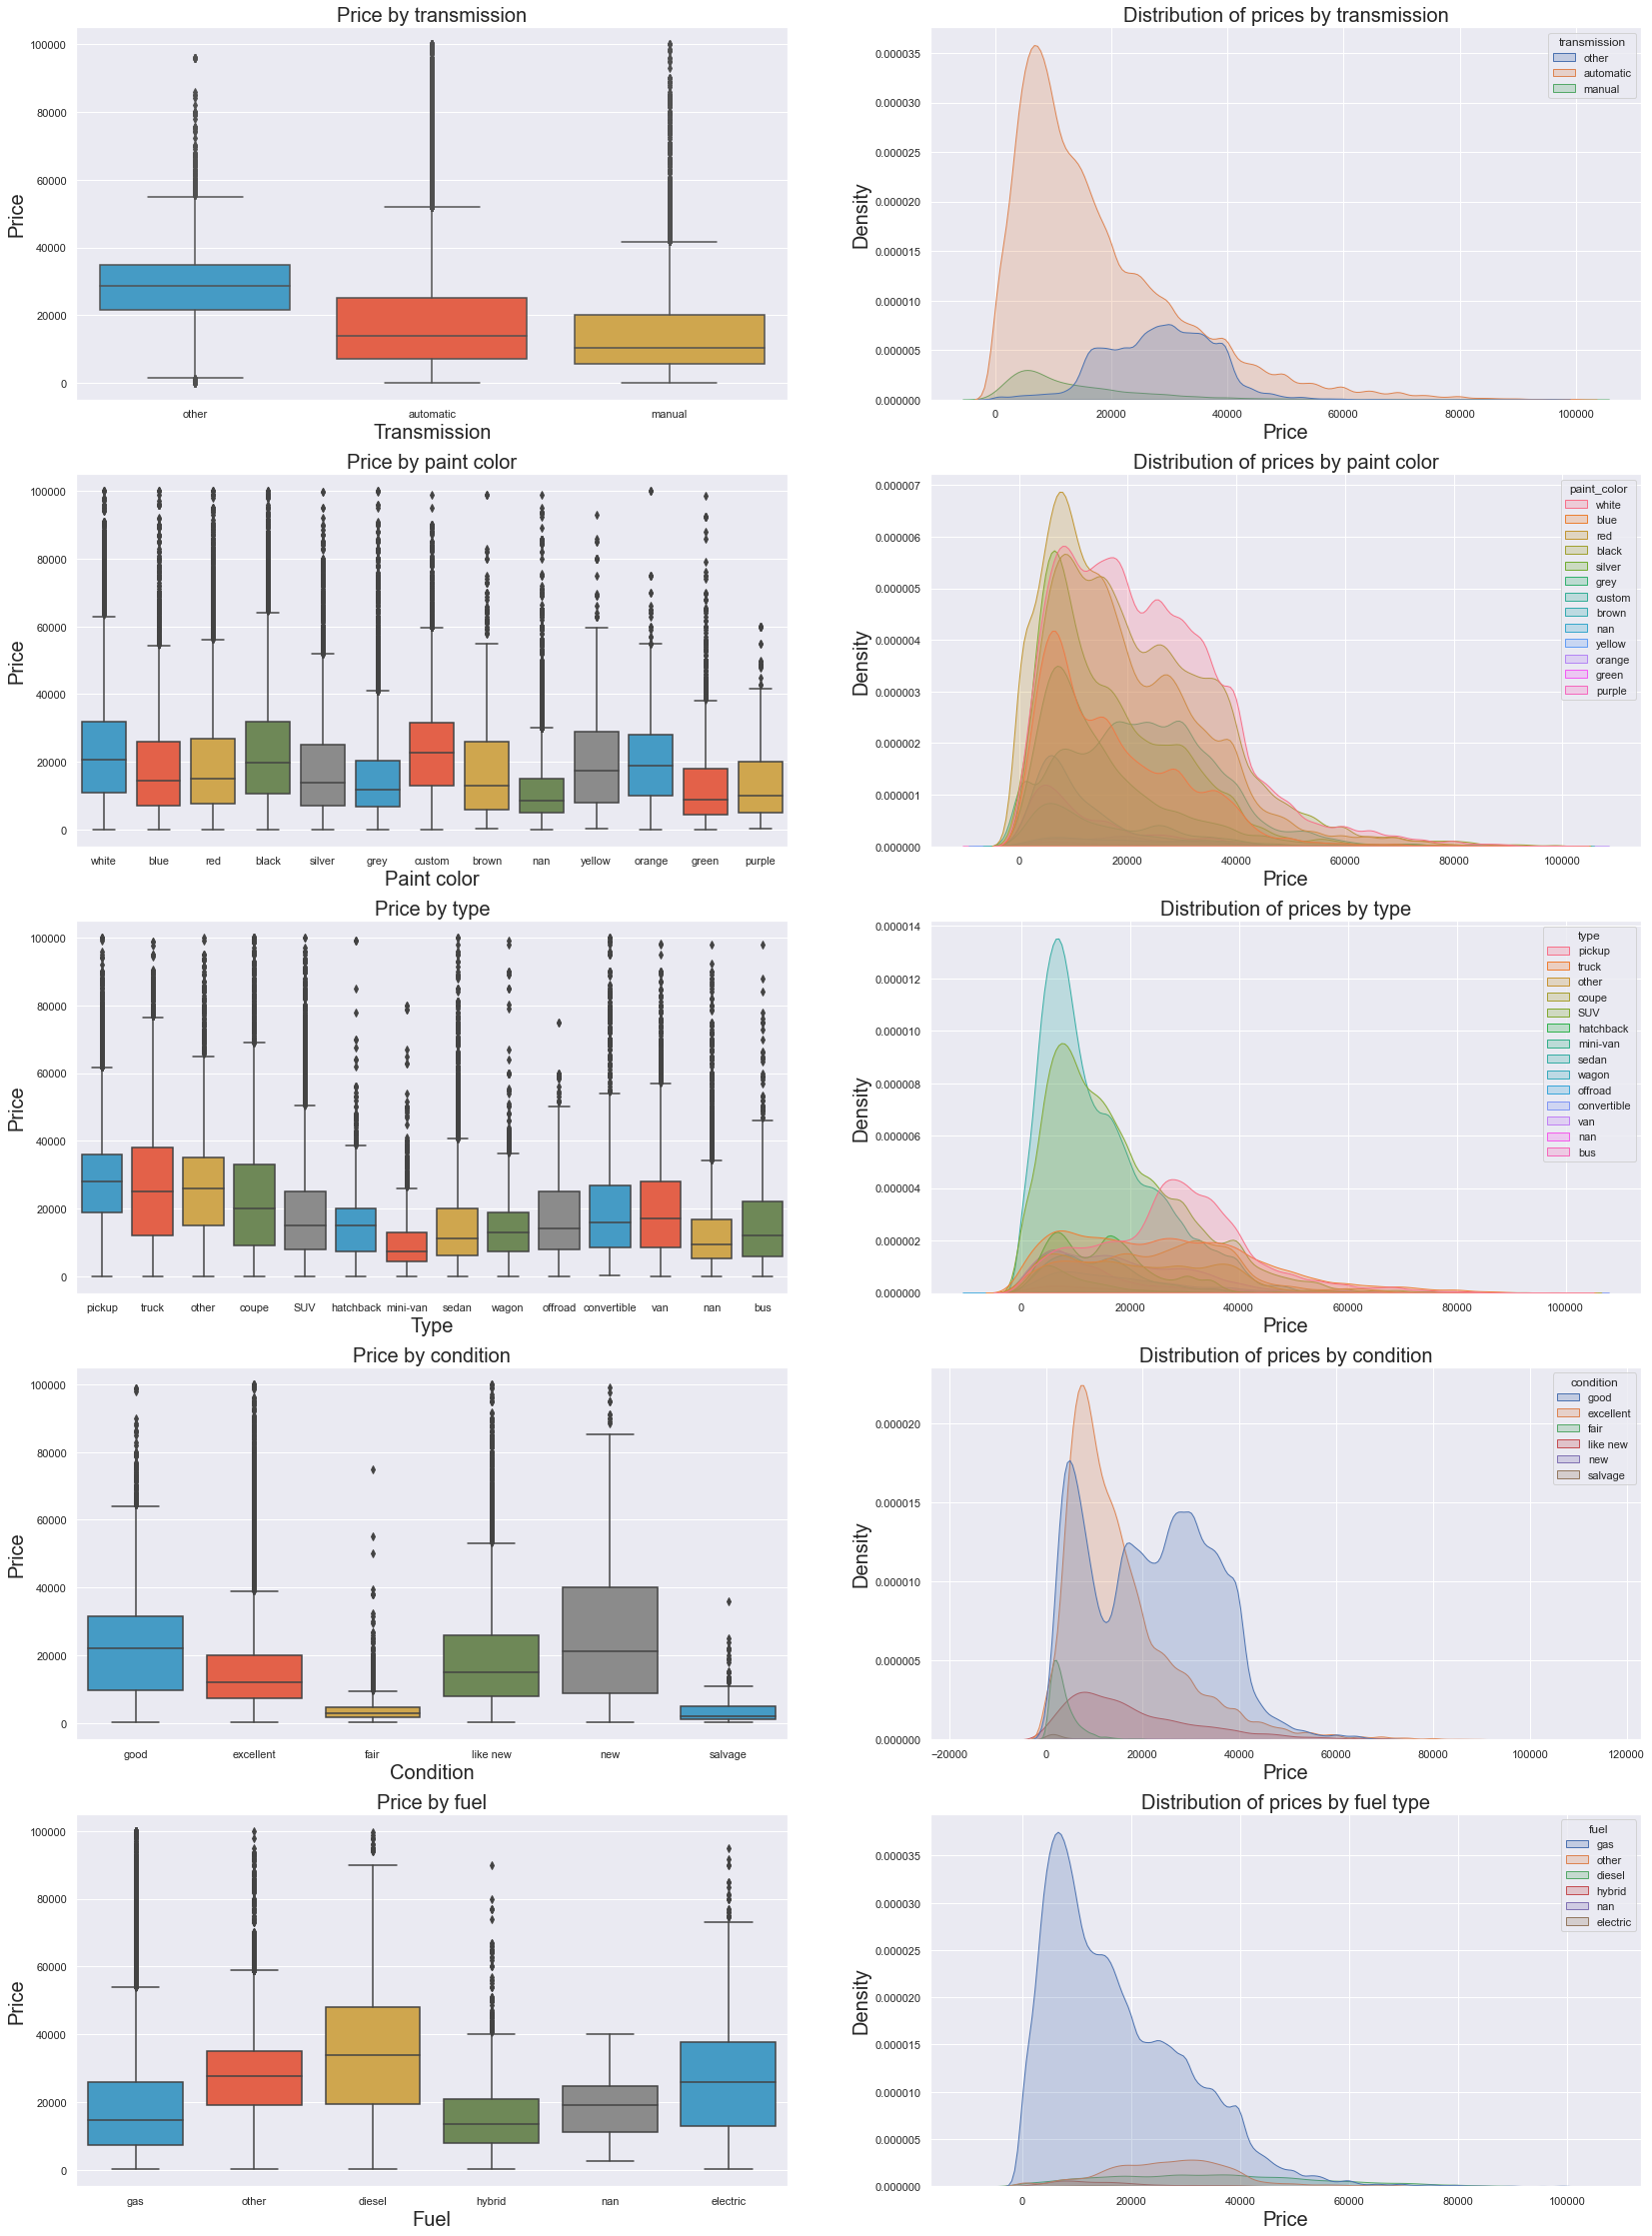

In [10]:
plt.subplot(5, 2, 1)
plt.subplots_adjust(bottom=5, top=7.5)
p = sns.boxplot(
    x="transmission", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 2)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="transmission", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by transmission", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 3)
p = sns.boxplot(
    x="paint_color", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 4)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="paint_color", fill=True, data=cars)
p.set_title("Distribution of prices by paint color", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 5)
p = sns.boxplot(
    x="type", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by type", fontsize=20)
p.set_xlabel("Type", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 6)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="type", fill=True, data=cars)
p.set_title("Distribution of prices by type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)

plt.subplot(5, 2, 7)
p = sns.boxplot(
    x="condition", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 8)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="condition", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by condition", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 9)
p = sns.boxplot(
    x="fuel", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by fuel", fontsize=20)
p.set_xlabel("Fuel", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 10)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="fuel", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by fuel type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)

Out of the categories above, condition and type show the highest discrepancy between the distribution of prices of different categories This suggests that condition and eventually type might be suitable to use as explanatory variables for the price. Moreover, prices over 60000 fall out of the 1.5xIQR range for all the categories, so will consider these as outliers. In the presence of outliers, I don't expect the model to have good price prediction capabilites, so will drop any observation with a price over 60000.

In [11]:
cars = cars[(cars["price"] < 60000)]

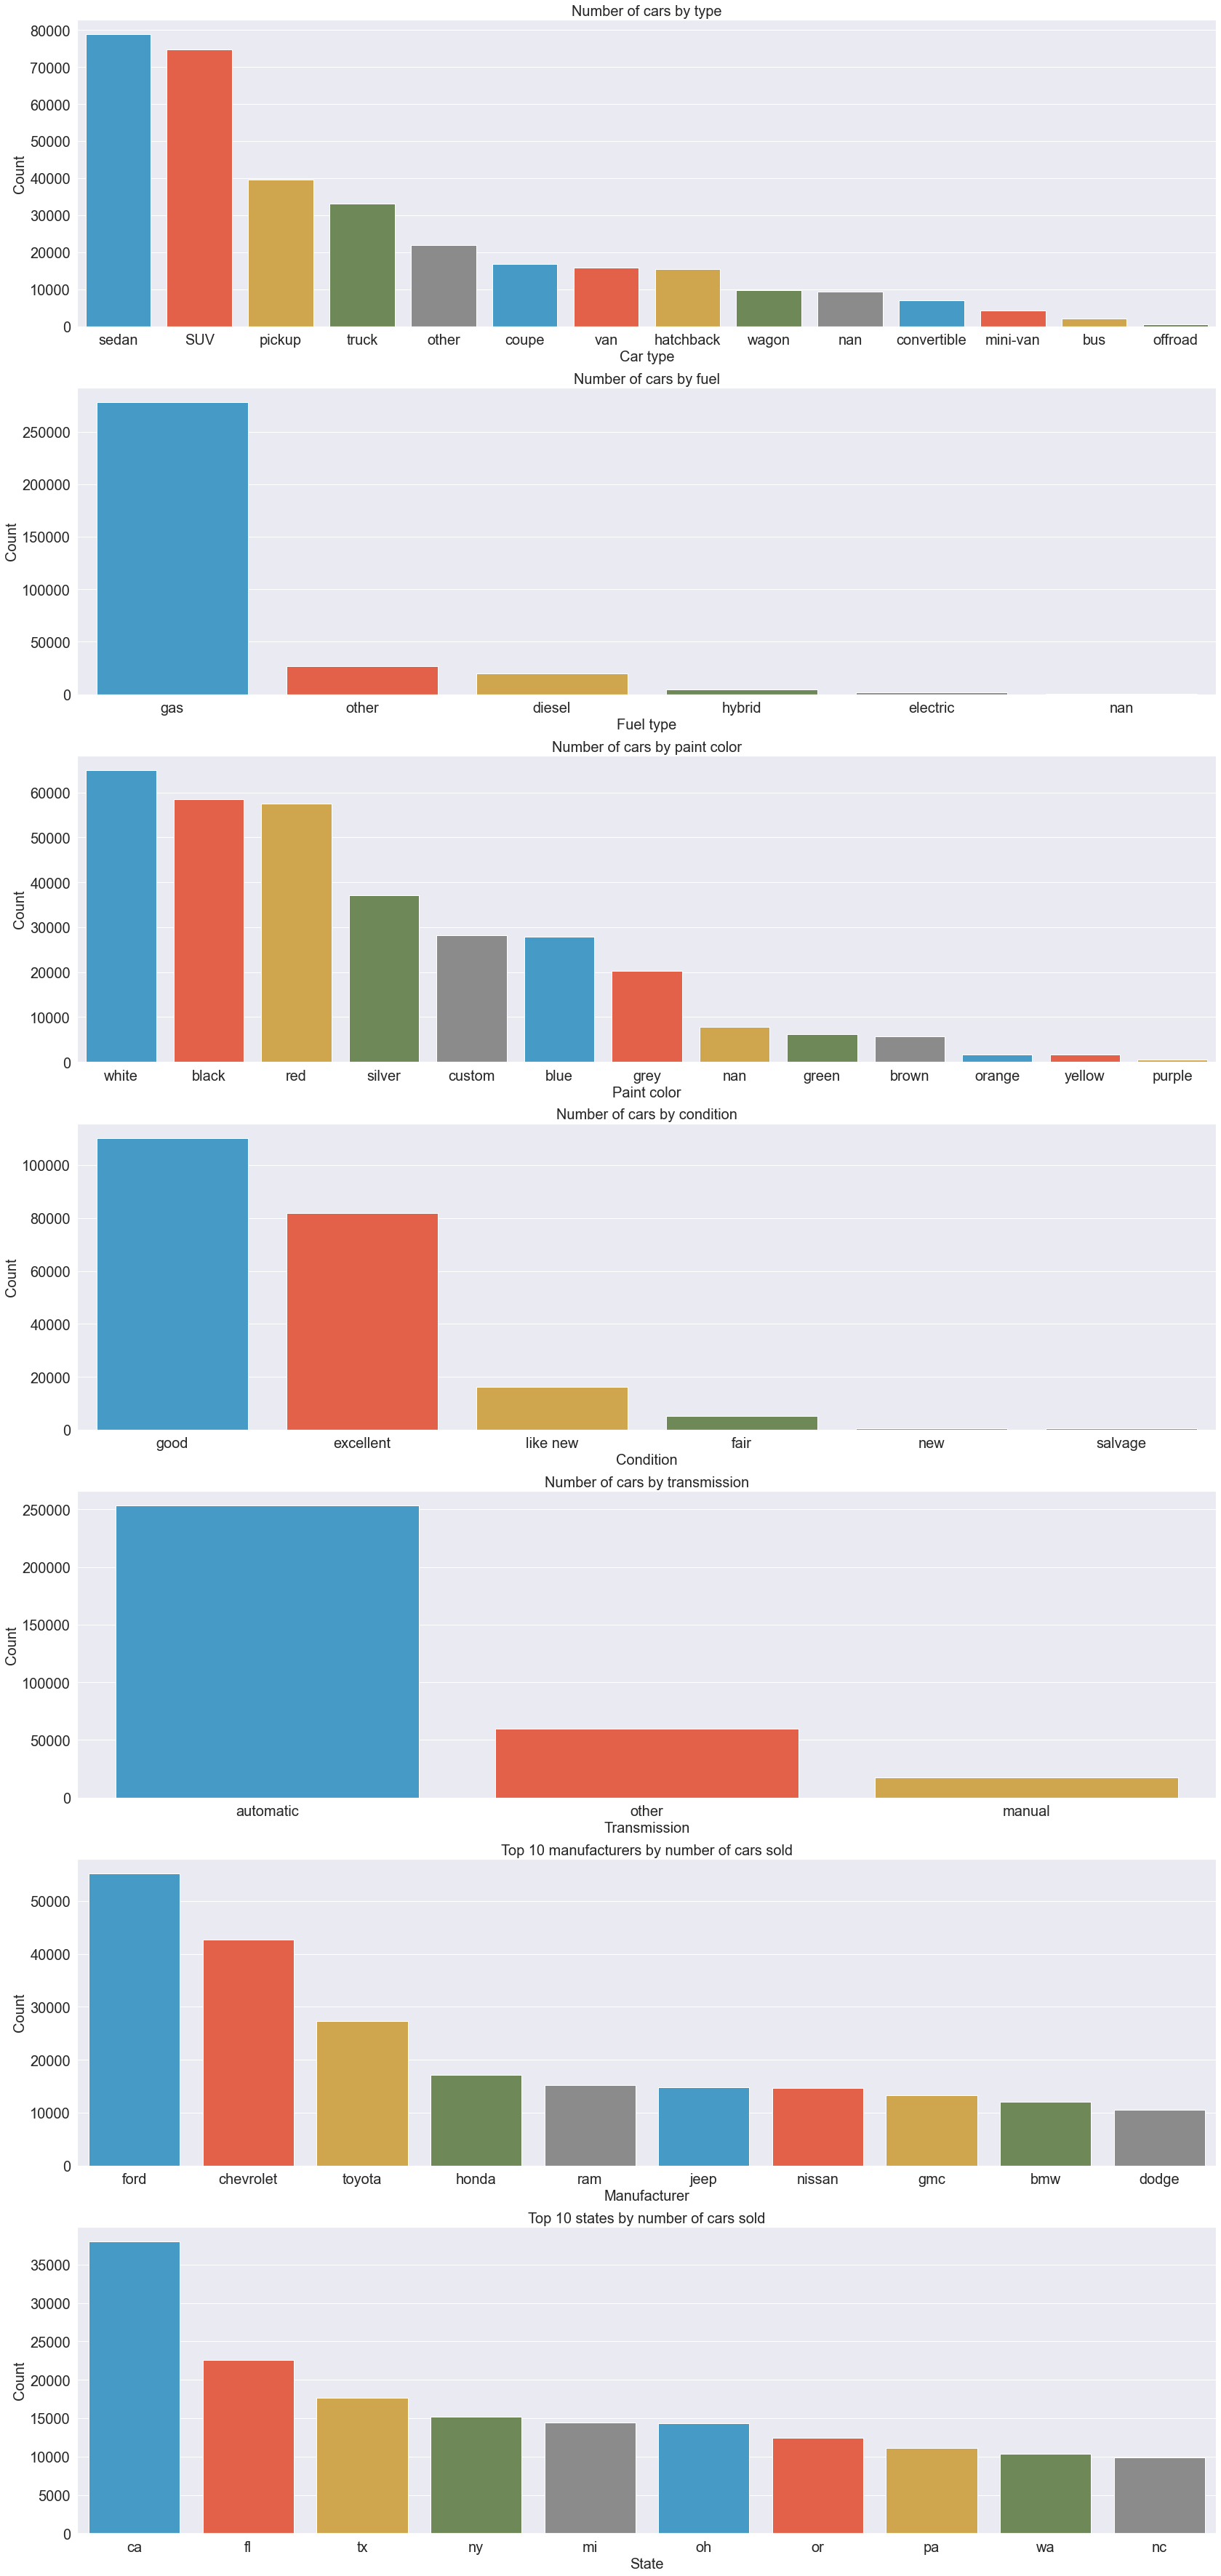

In [12]:
plt.subplots_adjust(bottom=4, top=8)
plt.subplot(7, 1, 1)
p = sns.countplot(
    x="type",
    order=cars["type"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by type", fontsize=20)
p.set_xlabel("Car type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 2)
p = sns.countplot(
    x="fuel", 
    order=cars["fuel"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by fuel", fontsize=20)
p.set_xlabel("Fuel type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 3)
p = sns.countplot(
    x="paint_color", 
    order=cars["paint_color"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 4)
p = sns.countplot(
    x="condition", 
    order=cars["condition"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 5)
p = sns.countplot(
    x="transmission", 
    order=cars["transmission"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)


plt.subplot(7, 1, 6)
p = sns.countplot(
    x="manufacturer", 
    order=cars["manufacturer"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 manufacturers by number of cars sold", fontsize=20)
p.set_xlabel("Manufacturer", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 7)
p = sns.countplot(
    x="state", 
    order=cars["state"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 states by number of cars sold", fontsize=20)
p.set_xlabel("State", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

As expected the number of cars in different categories is unballanced.

#### Numerical variables. Are they correlated with price ?

Text(0, 0.5, 'Mileage')

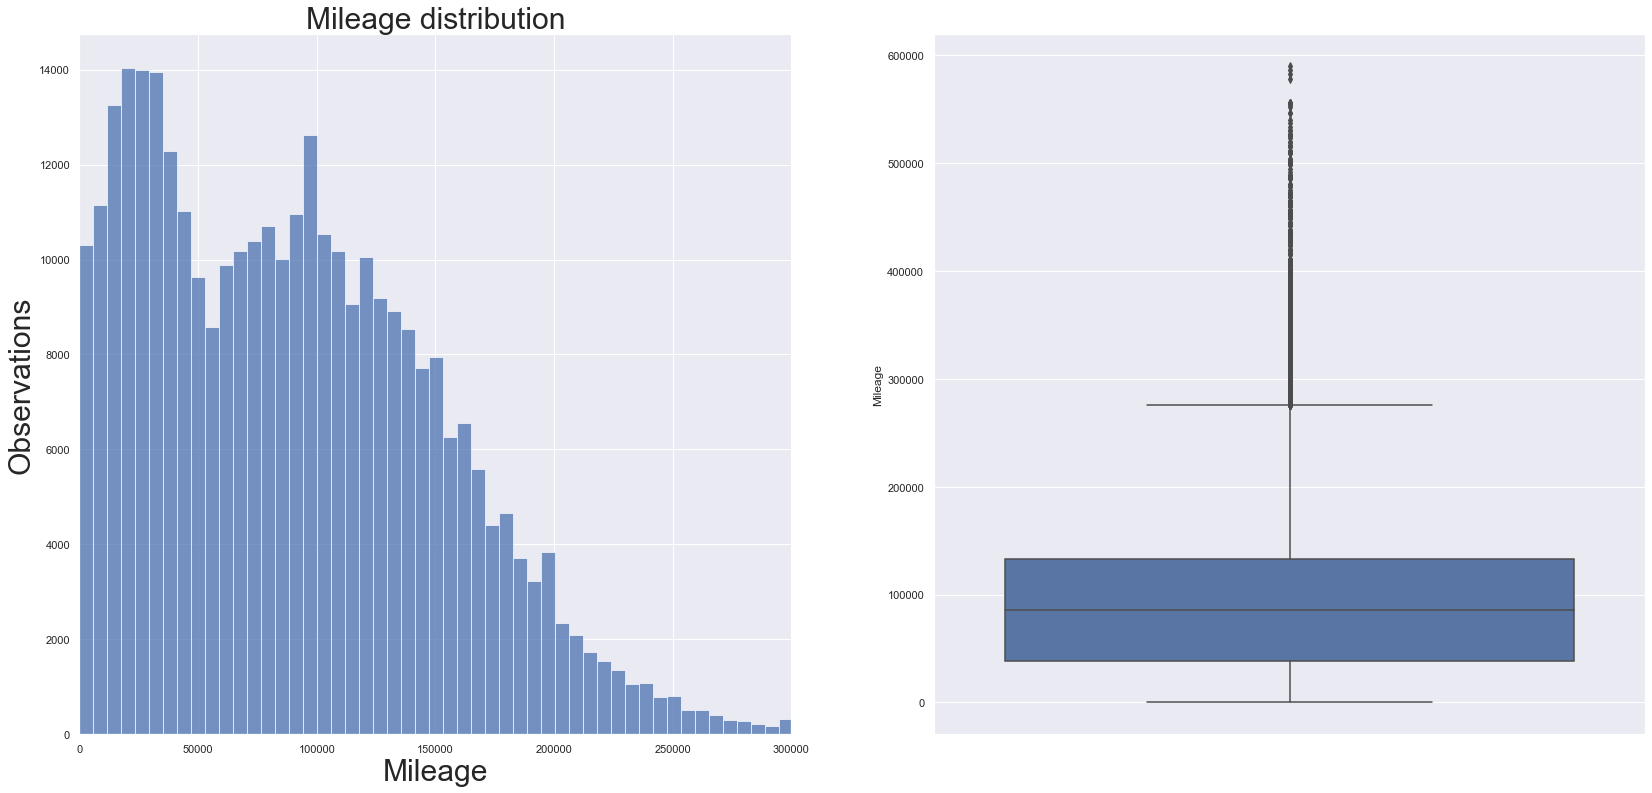

In [13]:
plt.subplot(1, 2, 1)
plt.ticklabel_format(style='plain', axis='x')
p = sns.histplot(cars["odometer"], bins=100)
p.axes.set_title("Mileage distribution",fontsize=30)
p.set_xlabel("Mileage",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 300000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.subplot(1, 2, 2)
p = sns.boxplot(y=cars["odometer"])
p.set_ylabel("Mileage")

Mileage shows a long tail of outlier points that fall outside the 1.5IQR range. Will remove all the observation over 300000.

In [14]:
cars = cars[cars["odometer"] < 300000]

Text(0, 0.5, 'Price')

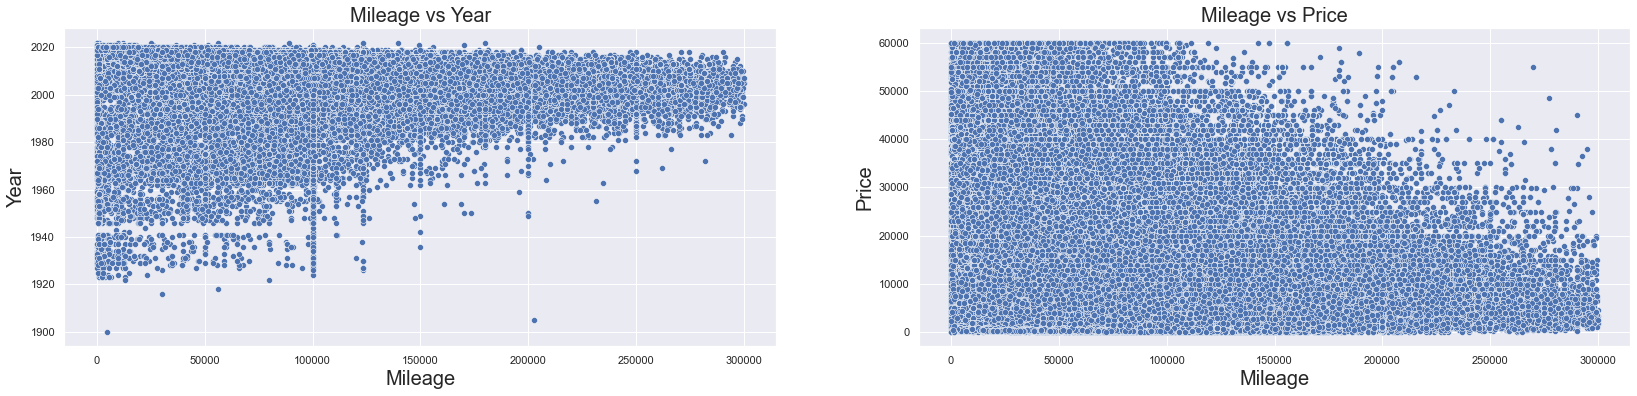

In [15]:
plt.subplot(2, 2, 1)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="year", data=cars)
p.set_title("Mileage vs Year", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Year", fontsize=20)
plt.subplot(2, 2, 2)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="price", data=cars)
p.set_title("Mileage vs Price", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Price", fontsize=20)

Price seem to decrease with the increase of mileage (which is expected). Similarly, older the car is, higher the mileage. 

<AxesSubplot:>

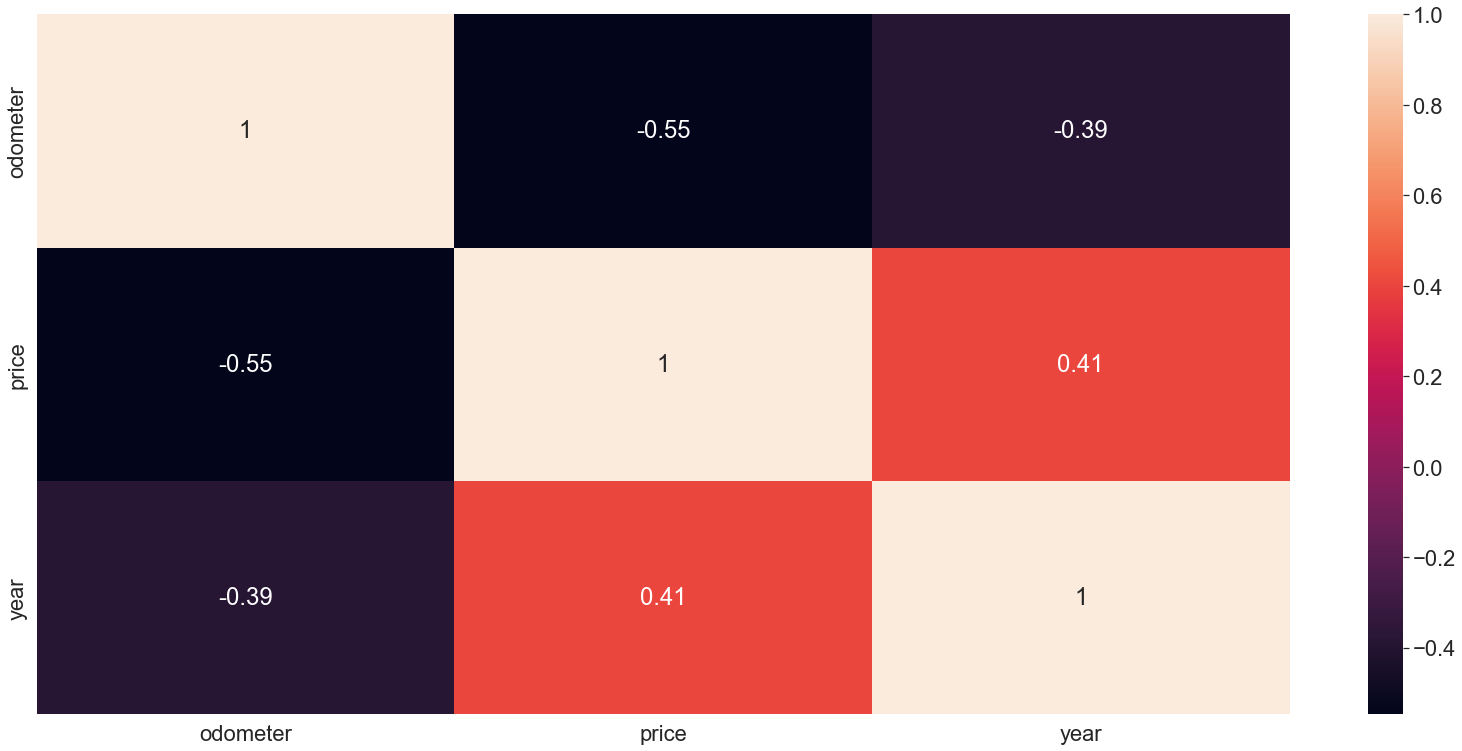

In [16]:
correlation = cars[["odometer", "price", "year"]].corr(method="pearson")
sns.set(font_scale=2)
sns.heatmap(correlation, annot=True)

Price and mileage and price and year seem to be correlated. That means that there's a dependency between them so year and mileage might will have some prediction power over the price. Given that none of the categorical features showed a good separation between the categories, will use these 2 numerical variables as explanatory variables for the price among some of the categorical features. 
The only concern here is the correlation between mileage and year, which could lead to an unstable model if they have a high VIF.

In order to avoid negative predictions for the price, will model the log price and transform the price back at the end.

### Feature transformation

In [17]:
from sklearn.preprocessing import StandardScaler

Features considered are odometer, state, type and year. Changing and retraining the models require just to specify the features below and everything can be re-trained without changes.

In [18]:
cars_sub = cars[["odometer", "state", "type", "year"] + ["price"]]

In [19]:
cars_sub = pd.get_dummies(
    data=cars_sub, 
    prefix=["state", "type"],
    columns=["state", "type"])

ss = StandardScaler()
cars_sub["odometer"] = ss.fit_transform(cars_sub["odometer"][:, np.newaxis])

/var/folders/4j/nwn878q577s1s_pmzlyckl_00000gn/T/ipykernel_6602/2765176273.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cars_sub["odometer"] = ss.fit_transform(cars_sub["odometer"][:, np.newaxis])


In [20]:
cars_sub["logprice"] = np.log(cars_sub["price"])

### Model building

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [22]:
X_train, X_test, y_train, y_test = train_test_split(cars_sub, cars_sub["logprice"], test_size=0.2)

# drop the prediction columns so we don't use them when we do stepwise feature selection
X_train = X_train.drop(columns=["price", "logprice"])
X_test = X_test.drop(columns=["price", "logprice"])

In [23]:
def mse(y, yhat):
    return np.sqrt(mean_squared_error(np.exp(y), np.exp(yhat)))

def get_errors(model_name, y, yhat):
    mean_squared_error(y, yhat)
    
    return pd.DataFrame({
        "Model Name": model_name,
        "RMSE": np.sqrt(mean_squared_error(y, yhat))
    }, index=[0])

def get_score(model_name, scores):
    return pd.DataFrame({"Model Name": model_name, "RMSE": np.mean(scores)}, index=[0])

def compute_errors(model, name, X, y):
    yhat = model.predict(X)
    return get_errors(name, np.exp(y), np.exp(yhat))

rmse_score = make_scorer(mse, greater_is_better = False)

##### Baseline model
Dummy model that predicts the average for any observation. Will use this as baseline to compare the rest of the models.

In [24]:
yhat_baseline = np.repeat(y_test.mean(), len(y_test))
baseline_result = get_errors('Average Model', np.exp(y_test), np.exp(yhat_baseline))
baseline_result

,Model Name,RMSE
0,Average Model,14019.831202


#### Linear regression model

In [25]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [26]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_result = compute_errors(lm, "Linear Regression", X_test, y_test)
lm_result

,Model Name,RMSE
0,Linear Regression,9767.856495


#### Lasso model and hyperparameter tuning for the regularization parameter

In [27]:
hyperparams = [{'alpha': np.arange(0.01, 10, 0.5)}]

In [28]:
model_cv = GridSearchCV(estimator = Lasso(), 
    param_grid = hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
lasso_result = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Ridge model and hyperparameter tuning for the regularization parameter

In [29]:
model_cv = GridSearchCV(estimator = Ridge(), 
    param_grid = hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
ridge_result = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


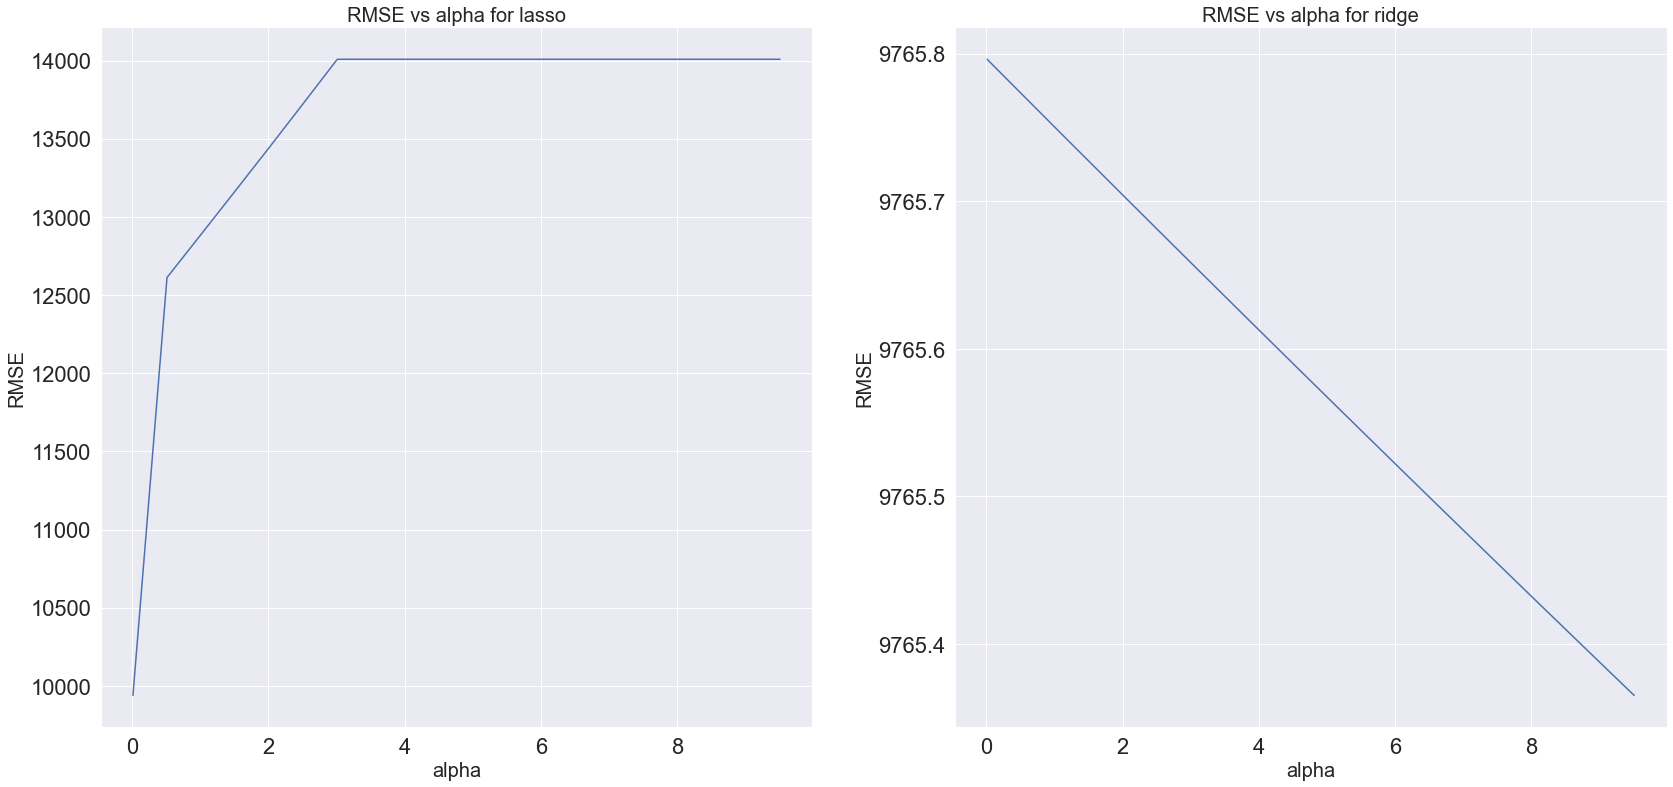

In [30]:
plt.subplot(1, 2, 1)
p = sns.lineplot(x=hyperparams[0]["alpha"], y=np.abs(lasso_result.cv_results_["mean_test_score"]))
p.set_title(f"RMSE vs alpha for lasso", fontsize=20)
p.set_xlabel("alpha", fontsize=20)
p.set_ylabel("RMSE", fontsize=20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.subplot(1, 2, 2)
p = sns.lineplot(x=hyperparams[0]["alpha"], y=np.abs(ridge_result.cv_results_["mean_test_score"]))
p.set_title(f"RMSE vs alpha for ridge", fontsize=20)
p.set_xlabel("alpha", fontsize=20)
p.set_ylabel("RMSE", fontsize=20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

In [31]:
lasso_result.best_estimator_.fit(X_train, y_train)
ridge_result.best_estimator_.fit(X_train, y_train)
regularized_models = pd.concat([
    compute_errors(lasso_result.best_estimator_, "Lasso Regression", X_test, y_test),
    compute_errors(ridge_result.best_estimator_, "Ridge Regression", X_test, y_test)
])
regularized_models

,Model Name,RMSE
0,Lasso Regression,9939.316905
0,Ridge Regression,9767.487142


#### Random forrest regression

In [32]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
rf_result = compute_errors(rf, "Random Forrest Regression", X_test, y_test)
rf_result

,Model Name,RMSE
0,Random Forrest Regression,6426.36351


In [33]:
rf_hyperparams = [{"n_estimators": [1, 10, 30, 50]}]

In [34]:
model_cv = GridSearchCV(estimator = RandomForestRegressor(n_estimators=100, n_jobs=-1), 
    param_grid = rf_hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
rf_result_cv = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [35]:
rf_cv_result = compute_errors(rf_result_cv.best_estimator_, "Random Forrest Regression CV", X_test, y_test)
rf_cv_result

,Model Name,RMSE
0,Random Forrest Regression CV,6460.165838


In [36]:
pd.concat(
    [regularized_models, baseline_result, lm_result, rf_result, rf_cv_result],
    ignore_index=True
).sort_values("RMSE")

,Model Name,RMSE
4,Random Forrest Regression,6426.363510
5,Random Forrest Regression CV,6460.165838
1,Ridge Regression,9767.487142
3,Linear Regression,9767.856495
0,Lasso Regression,9939.316905
2,Average Model,14019.831202


The Random forrest model performs the best, when the models are compared using RMSE. The penalised regression models didn't bring any benefits. For the feature set choosen the model without penalty had almost identical RMSE score.

### Prediction results 

Text(0.5, 1.0, 'Price vs Year')

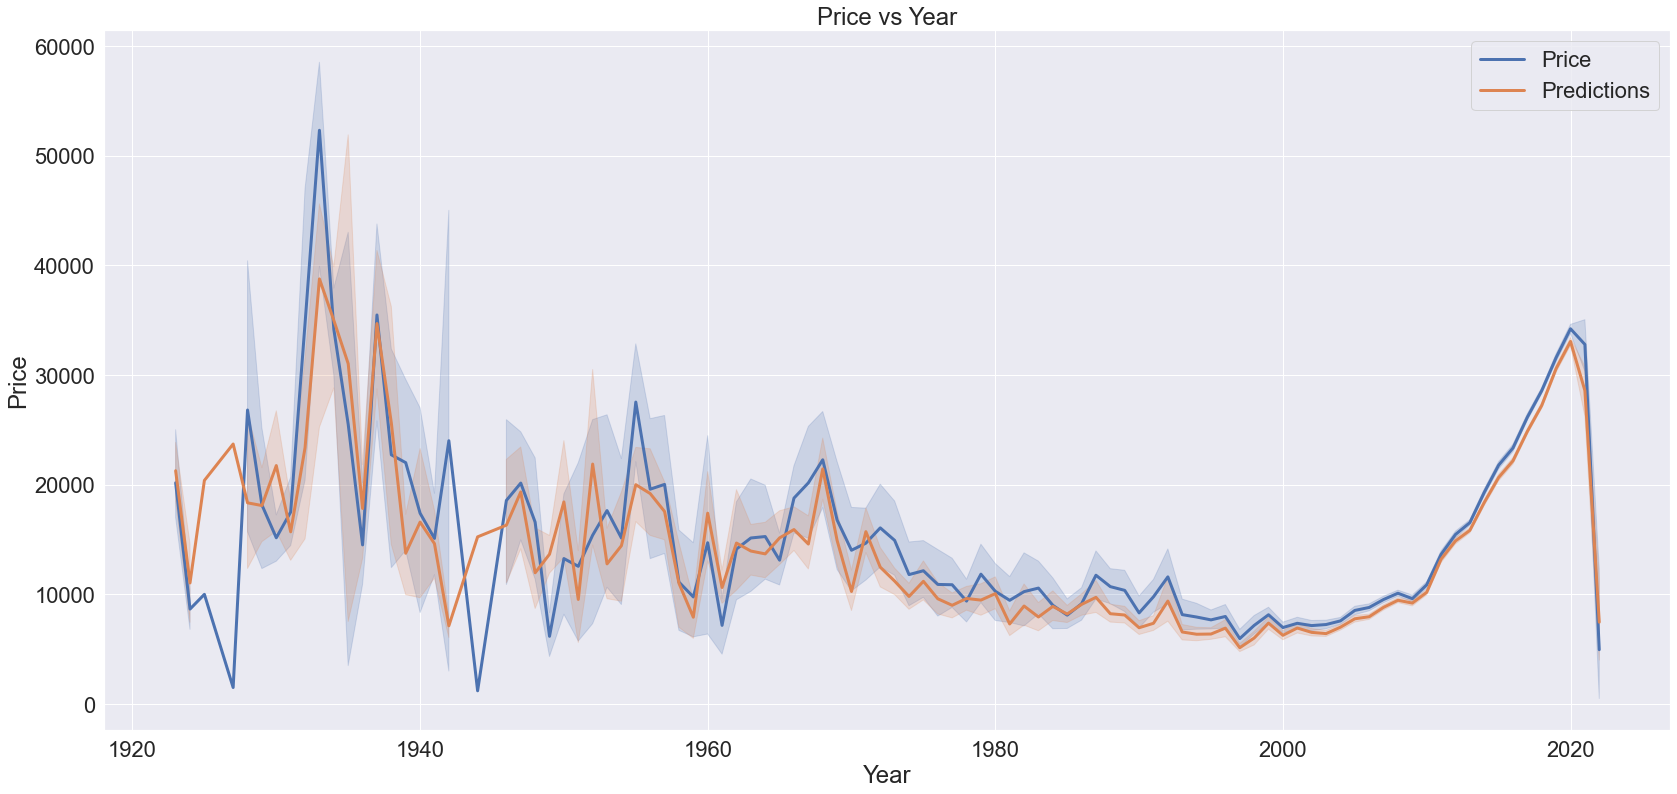

In [37]:
predictions = rf_result_cv.best_estimator_.predict(X_test)

plt.subplot(1, 1, 1)
sns.lineplot( x=X_test["year"], y=np.exp(y_test), label="Price", linewidth=3)
p = sns.lineplot( x=X_test["year"], y=np.exp(predictions), label="Predictions", linewidth=3)
p.set_ylabel("Price")
p.set_xlabel("Year")
p.set_title("Price vs Year")

We can see that for cars that are after 2000, the model predicts the price fairly well, in average, however older cars aren't predicted that well. The biggest problem seems to represent the period 1925-1940 which I suspect contains cars that might be considered rare or collectible hence could have a higher price then the rest. Some filtering on the data shows that the period contains a high number of coupe cars, compared to the general trend that has sedan cars with the higher frequency which would support this hypothesis.

Increasing the performance of the prediction might be possible by using more features existing in the dataset, considering different models (maybe splines with knots situated at various years) or even doing more feature engineering. Some features might be cleaned even better, or some other features might be created by considering rich/poor areas, periods with higher probability of luxury cars, etc.